In [ ]:
import torch
print(torch.__version__)

2.5.1


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset
from collections import defaultdict
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import os.path
import time
import matplotlib.pyplot as plt
from scipy.stats import dirichlet
import copy
import seaborn as sns
import pandas as pd
from opacus import PrivacyEngine

In [ ]:
#dataset
# Walk through the local directories (update with your local paths)
for dirname, _, filenames in os.walk('C:/Users/kimji/OneDrive/Desktop/archive/Testing'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('C:/Users/kimji/OneDrive/Desktop/archive/Training'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:/Users/kimji/OneDrive/Desktop/archive/Testing\glioma\Te-glTr_0000.jpg
C:/Users/kimji/OneDrive/Desktop/archive/Testing\glioma\Te-glTr_0001.jpg
C:/Users/kimji/OneDrive/Desktop/archive/Testing\glioma\Te-glTr_0002.jpg
C:/Users/kimji/OneDrive/Desktop/archive/Testing\glioma\Te-glTr_0003.jpg
C:/Users/kimji/OneDrive/Desktop/archive/Testing\glioma\Te-glTr_0004.jpg
C:/Users/kimji/OneDrive/Desktop/archive/Testing\glioma\Te-glTr_0005.jpg
C:/Users/kimji/OneDrive/Desktop/archive/Testing\glioma\Te-glTr_0006.jpg
C:/Users/kimji/OneDrive/Desktop/archive/Testing\glioma\Te-glTr_0007.jpg
C:/Users/kimji/OneDrive/Desktop/archive/Testing\glioma\Te-glTr_0008.jpg
C:/Users/kimji/OneDrive/Desktop/archive/Testing\glioma\Te-glTr_0009.jpg
C:/Users/kimji/OneDrive/Desktop/archive/Testing\glioma\Te-gl_0010.jpg
C:/Users/kimji/OneDrive/Desktop/archive/Testing\glioma\Te-gl_0011.jpg
C:/Users/kimji/OneDrive/Desktop/archive/Testing\glioma\Te-gl_0012.jpg
C:/Users/kimji/OneDrive/Desktop/archive/Testing\glioma\Te-gl_0013.jpg


In [ ]:
# Configuration
config = {
    "batch_size": 16,
    "learning_rate": 0.001,
    "num_epochs": 10,
    "num_clients": 4,
    "num_rounds": 20,
    "image_size": (224, 224),
    "num_classes": 4,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "train_path": "C:/Users/kimji/OneDrive/Desktop/archive/Training",  # Local path for training data
    "test_path": "C:/Users/kimji/OneDrive/Desktop/archive/Testing",    # Local path for testing data
    "normalize_mean": [0.485, 0.456, 0.406],
    "normalize_std": [0.229, 0.224, 0.225],
    "dir_alpha": 10,  # Dirichlet parameter for controlling distribution
}


In [ ]:
# transformation
transform = transforms.Compose([
    transforms.Resize(config["image_size"]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=config["normalize_mean"], std=config["normalize_std"])
])

In [ ]:
# Define training and testing folders
train_path = "C:/Users/kimji/OneDrive/Desktop/archive/Training"
test_path = "C:/Users/kimji/OneDrive/Desktop/archive/Testing"

In [ ]:
#Load training & testing datasets
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

num_classes = len(train_dataset.classes)
print(f"Training Data: {len(train_dataset)} images across {num_classes} classes.")
print(f"Testing Data: {len(test_dataset)} images across {num_classes} classes.")
print(f"Classes: {train_dataset.classes}")

Training Data: 5712 images across 4 classes.
Testing Data: 1311 images across 4 classes.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [ ]:
# Function for Dirichlet-based Data Splitting
def dirichlet_split_noniid(dataset, num_clients, alpha=7, max_attempts=10):
    """
    Splits dataset using Dirichlet distribution where each client gets a portion of each class
    Ensures each client gets at least one sample using min size
    the method takes the dataset , how many clients to divide on , max attempt so you do not get into an infinte loop
    """
    num_classes = len(dataset.classes)
    labels = np.array([label for _, label in dataset.samples])

    min_size = 0
    attempts = 0

    while min_size < 1 and attempts < max_attempts:
        attempts += 1
        idx_by_class = [np.where(labels == i)[0] for i in range(num_classes)]
        proportions = np.random.dirichlet([alpha] * num_clients, num_classes)
        client_indices = [[] for _ in range(num_clients)]

        for c, idx in enumerate(idx_by_class):
            np.random.shuffle(idx)
            split_indices = (proportions[c] * len(idx)).astype(int)
            split_indices[-1] = len(idx) - sum(split_indices[:-1])
            start_idx = 0

            for client_idx in range(num_clients):
                end_idx = start_idx + split_indices[client_idx]
                client_indices[client_idx].extend(idx[start_idx:end_idx])
                start_idx = end_idx

        min_size = min(len(indices) for indices in client_indices)

    if min_size < 1:
        print("Warning: Could not guarantee at least one sample per client after max_attempts.")

    print(f"Training dataset split among {num_clients} clients successfully!")

    return [Subset(dataset, indices) for indices in client_indices], client_indices


In [ ]:
def plot_client_data_distribution(client_indices, labels, dataset, num_clients):
    """
    it takes:
    - client_indices: List of indices for each client
    - labels: Array of dataset labels
    - dataset: The dataset object to extract class names
    - num_clients: Number of FL clients
    shows the distribution of data among clients
    """
    plt.figure(figsize=(12, 6))
    bar_width = 0.12  # Adjust width to prevent overlap
    num_classes = len(dataset.classes)
    x = np.arange(num_classes)  # X positions for bars

    for i, indices in enumerate(client_indices):
        client_label_counts = np.bincount([labels[idx] for idx in indices], minlength=num_classes)
        plt.bar(x + i * bar_width, client_label_counts, width=bar_width, color=plt.cm.tab10(i), alpha=0.7, label=f'Client {i+1}')

    plt.xticks(x + (num_clients * bar_width) / 2, dataset.classes, rotation=45)
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title("Data Distribution Among Clients (Dirichlet Split)")
    plt.legend()
    plt.show()


Splitting dataset...
Training dataset split among 4 clients successfully!
Dataset successfully split in 0.00 seconds.


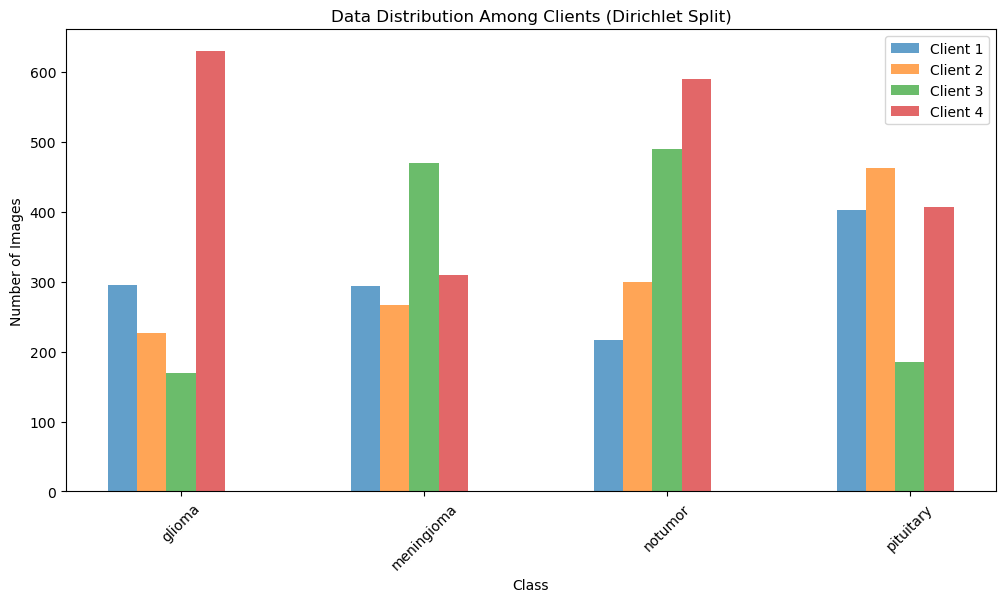

In [ ]:
#Apply Dirichlet-based splitting
print("Splitting dataset...")
start_time = time.time()
client_datasets, client_indices = dirichlet_split_noniid(train_dataset, config["num_clients"], alpha=config["dir_alpha"])
end_time = time.time()
print(f"Dataset successfully split in {end_time - start_time:.2f} seconds.")
# Plot data distribution
plot_client_data_distribution(client_indices, np.array([label for _, label in train_dataset.samples]), train_dataset, config["num_clients"])


In [ ]:
#Show the data splits per client
for i, client_dataset in enumerate(client_datasets):
    class_counts = defaultdict(int)
    for _, label in client_dataset:
        class_counts[train_dataset.classes[label]] += 1

    print(f"Client {i+1}: {class_counts}")

Client 1: defaultdict(<class 'int'>, {'glioma': 295, 'meningioma': 294, 'notumor': 217, 'pituitary': 402})
Client 2: defaultdict(<class 'int'>, {'glioma': 227, 'meningioma': 266, 'notumor': 299, 'pituitary': 463})
Client 3: defaultdict(<class 'int'>, {'glioma': 170, 'meningioma': 470, 'notumor': 490, 'pituitary': 185})
Client 4: defaultdict(<class 'int'>, {'glioma': 629, 'meningioma': 309, 'notumor': 589, 'pituitary': 407})


In [ ]:
#Create DataLoaders for Federated Learning
client_loaders = [DataLoader(client_data, batch_size=config["batch_size"], shuffle=True) for client_data in client_datasets]
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)
print("DataLoaders ready!")

DataLoaders ready!


In [ ]:
#Define the CNN model
class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 56 * 56, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
# Federated Averaging Function
def fed_avg(models):
    """
    Takes a list of trained local models and averages their weights to update the global model.
    returns Aggregated global model with averaged weights
    """
    model_weights = [m.state_dict() for m in models]  # Extract model weights (state_dict) from each client
    avg_weights = copy.deepcopy(model_weights[0])  # Create a copy to avoid modifying original weights

    for key in avg_weights.keys():
        for i in range(1, len(model_weights)):
            avg_weights[key] += model_weights[i][key]  # Sum weights
        avg_weights[key] = torch.div(avg_weights[key], len(model_weights))  # Average weights

    global_model = copy.deepcopy(models[0])  # Copy one model as the global model
    global_model.load_state_dict(avg_weights)  # Load averaged weights into the global model
    return global_model


In [ ]:
config["target_delta"] = 1e-5  # A common default value for DP-SGD

# Define DP-SGD Training Function
from opacus import PrivacyEngine

def train_dp(model, dataloader, optimizer, criterion):
    """
    takes one local model and its data loader , optimizer and loss function
    Train a local model using DP-SGD with Opacus.
    return Average loss, accuracy, precision, recall, F1-score, and privacy budget (ε)
    """
    model.train()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    # Initialize Opacus Privacy Engine
    privacy_engine = PrivacyEngine()

    # Attach privacy engine (corrected method)
    model, optimizer, dataloader = privacy_engine.make_private(
        module=model,
        optimizer=optimizer,
        data_loader=dataloader,
        noise_multiplier=1.2,  # Adjust privacy noise
        max_grad_norm=1.0,  # Gradient clipping
    )

    for images, labels in dataloader:
        images, labels = images.to(config["device"]), labels.to(config["device"])

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Compute evaluation metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)

    # ✅ **Fixed privacy budget retrieval**
    epsilon = privacy_engine.get_epsilon(config["target_delta"])
    print(f"Privacy Budget (ε) After Training: {epsilon:.2f}")

    return total_loss / len(dataloader), accuracy, precision, recall, f1, epsilon


In [ ]:
#testing
def test(model, dataloader, criterion):
    """
    Evaluate the global model on the test dataset and compute metrics.
    """
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(config["device"]), labels.to(config["device"])  # Move to correct device

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())  # Move to CPU before .numpy()
            all_labels.extend(labels.cpu().numpy())

    # Compute evaluation metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)

    return total_loss / len(dataloader), accuracy, precision, recall, f1

In [ ]:
# Initialize global model and loss function
global_model = BrainTumorCNN(num_classes=config["num_classes"]).to(config["device"])
criterion = nn.CrossEntropyLoss()

# Initialize lists to store training and evaluation history
train_losses, test_losses = [], []
train_accuracy, test_accuracy = [], []
train_precision, test_precision = [], []
train_recall, test_recall = [], []
train_f1, test_f1 = [], []
train_epsilons, test_epsilons = [], []

In [ ]:
#Federated Learning Setup - server side

# Initialize list to track privacy budget (ε) per round
epsilon_per_round = []

print("\nStarting Federated Learning with DP-SGD...")
client_train_history = {i: {"accuracy": [], "loss": [], "precision": [], "recall": [], "f1": [], "epsilon": []} for i in range(config["num_clients"])}  # Moved outside loop

for round in range(config["num_rounds"]):
    print(f"\n Round {round+1}")

    local_models = []
    round_train_losses, round_train_accuracy = [], []
    round_train_precision, round_train_recall, round_train_f1 = [], [], []
    client_epsilons = []  # Track per-client privacy budget
    client_data_sizes = []

    # Train clients with DP-SGD
    for i, dataloader in enumerate(client_loaders):
        client_model = BrainTumorCNN(num_classes=config["num_classes"]).to(config["device"])  # Move to device
        client_model.load_state_dict(global_model.state_dict())  # Copy global model

        optimizer = optim.SGD(client_model.parameters(), lr=config["learning_rate"], momentum=0.9)  # ✅ Using SGD for DP-SGD
        loss, acc, prec, rec, f1, epsilon = train_dp(client_model, dataloader, optimizer, criterion)  # ✅ Track DP-SGD

        local_models.append(client_model)

        # Store client metrics in history dictionary
        client_train_history[i]["accuracy"].append(acc)
        client_train_history[i]["loss"].append(loss)
        client_train_history[i]["precision"].append(prec)
        client_train_history[i]["recall"].append(rec)
        client_train_history[i]["f1"].append(f1)
        client_train_history[i]["epsilon"].append(epsilon)

        #Append training results to round-specific lists
        round_train_losses.append(loss)
        round_train_accuracy.append(acc)
        round_train_precision.append(prec)
        round_train_recall.append(rec)
        round_train_f1.append(f1)
        client_epsilons.append(epsilon)  # Store per-client ε value
        client_data_sizes.append(len(dataloader.dataset))

        print(f"Client {i+1} - Samples: {len(dataloader.dataset)}, Loss: {loss:.4f}, Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}, ε: {epsilon:.2f}")

    # Aggregate models using FedAvg
    global_model = fed_avg(local_models)

    #  Ensure `client_data_sizes` is not empty before division
    if sum(client_data_sizes) > 0:
        total_data = sum(client_data_sizes)
        avg_train_loss = sum([l * s for l, s in zip(round_train_losses, client_data_sizes)]) / total_data
        avg_train_acc = sum([a * s for a, s in zip(round_train_accuracy, client_data_sizes)]) / total_data
        avg_train_prec = sum([p * s for p, s in zip(round_train_precision, client_data_sizes)]) / total_data
        avg_train_rec = sum([r * s for r, s in zip(round_train_recall, client_data_sizes)]) / total_data
        avg_train_f1 = sum([f * s for f, s in zip(round_train_f1, client_data_sizes)]) / total_data
    else:
        avg_train_loss = avg_train_acc = avg_train_prec = avg_train_rec = avg_train_f1 = 0  # Default to 0 if no data

    # Compute average privacy budget (ε) across clients
    avg_epsilon = sum(client_epsilons) / len(client_epsilons)
    epsilon_per_round.append(avg_epsilon)  # Store for plotting

    # Store aggregated global training metrics
    train_losses.append(avg_train_loss)
    train_accuracy.append(avg_train_acc)
    train_precision.append(avg_train_prec)
    train_recall.append(avg_train_rec)
    train_f1.append(avg_train_f1)
    train_epsilons.append(avg_epsilon)

    print(f"🌎 Global Model After Round {round+1}:")
    print(f"   Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.4f}, Prec: {avg_train_prec:.4f}, Rec: {avg_train_rec:.4f}, F1: {avg_train_f1:.4f}, ε:{avg_epsilon:.2f}")

    # Evaluate the global model on the test dataset
    global_loss, global_acc, global_prec, global_rec, global_f1 = test(global_model, test_loader, criterion)

    # Store test performance
    test_losses.append(global_loss)
    test_accuracy.append(global_acc)
    test_precision.append(global_prec)
    test_recall.append(global_rec)
    test_f1.append(global_f1)

    print(f"Global Model Performance on Test Set:")
    print(f"   Loss: {global_loss:.4f}, Acc: {global_acc:.4f}, Prec: {global_prec:.4f}, Rec: {global_rec:.4f}, F1: {global_f1:.4f}")



Starting Federated Learning with DP-SGD...

 Round 1


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.55
Client 1 - Samples: 1208, Loss: 1.1727, Acc: 0.4742, Prec: 0.6215, Rec: 0.4742, F1: 0.3761, ε: 0.55


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.53
Client 2 - Samples: 1255, Loss: 1.1485, Acc: 0.4840, Prec: 0.5637, Rec: 0.4840, F1: 0.3716, ε: 0.53


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.52
Client 3 - Samples: 1315, Loss: 1.0778, Acc: 0.5041, Prec: 0.4888, Rec: 0.5041, F1: 0.4359, ε: 0.52


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.40
Client 4 - Samples: 1934, Loss: 1.0556, Acc: 0.5745, Prec: 0.4992, Rec: 0.5745, F1: 0.4910, ε: 0.40
🌎 Global Model After Round 1:
   Loss: 1.1059, Acc: 0.5172, Prec: 0.5369, Rec: 0.5172, F1: 0.4278, ε:0.50
Global Model Performance on Test Set:
   Loss: 1.1547, Acc: 0.5400, Prec: 0.5596, Rec: 0.5400, F1: 0.4679

 Round 2


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.55
Client 1 - Samples: 1208, Loss: 1.0646, Acc: 0.5878, Prec: 0.6419, Rec: 0.5878, F1: 0.5412, ε: 0.55


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.53
Client 2 - Samples: 1255, Loss: 1.0637, Acc: 0.5232, Prec: 0.6667, Rec: 0.5232, F1: 0.4123, ε: 0.53


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.52
Client 3 - Samples: 1315, Loss: 1.0408, Acc: 0.5600, Prec: 0.5634, Rec: 0.5600, F1: 0.5071, ε: 0.52


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.40
Client 4 - Samples: 1934, Loss: 0.9923, Acc: 0.5982, Prec: 0.5354, Rec: 0.5982, F1: 0.5290, ε: 0.40
🌎 Global Model After Round 2:
   Loss: 1.0344, Acc: 0.5707, Prec: 0.5932, Rec: 0.5707, F1: 0.5009, ε:0.50
Global Model Performance on Test Set:
   Loss: 1.0903, Acc: 0.6331, Prec: 0.6224, Rec: 0.6331, F1: 0.6055

 Round 3


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.55
Client 1 - Samples: 1208, Loss: 1.0549, Acc: 0.5559, Prec: 0.5960, Rec: 0.5559, F1: 0.5164, ε: 0.55


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.53
Client 2 - Samples: 1255, Loss: 1.1226, Acc: 0.5166, Prec: 0.5856, Rec: 0.5166, F1: 0.4308, ε: 0.53


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.52
Client 3 - Samples: 1315, Loss: 0.9645, Acc: 0.6076, Prec: 0.5909, Rec: 0.6076, F1: 0.5656, ε: 0.52


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.40
Client 4 - Samples: 1934, Loss: 0.9462, Acc: 0.6359, Prec: 0.6646, Rec: 0.6359, F1: 0.5812, ε: 0.40
🌎 Global Model After Round 3:
   Loss: 1.0122, Acc: 0.5863, Prec: 0.6158, Rec: 0.5863, F1: 0.5309, ε:0.50
Global Model Performance on Test Set:
   Loss: 1.0859, Acc: 0.6323, Prec: 0.6130, Rec: 0.6323, F1: 0.6136

 Round 4


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.55
Client 1 - Samples: 1208, Loss: 0.9822, Acc: 0.5916, Prec: 0.6342, Rec: 0.5916, F1: 0.5511, ε: 0.55


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.53
Client 2 - Samples: 1255, Loss: 1.0147, Acc: 0.5579, Prec: 0.6092, Rec: 0.5579, F1: 0.4829, ε: 0.53


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.52
Client 3 - Samples: 1315, Loss: 0.9143, Acc: 0.6373, Prec: 0.6462, Rec: 0.6373, F1: 0.5959, ε: 0.52


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.40
Client 4 - Samples: 1934, Loss: 0.9196, Acc: 0.6546, Prec: 0.6514, Rec: 0.6546, F1: 0.6016, ε: 0.40
🌎 Global Model After Round 4:
   Loss: 0.9525, Acc: 0.6161, Prec: 0.6373, Rec: 0.6161, F1: 0.5635, ε:0.50
Global Model Performance on Test Set:
   Loss: 1.1225, Acc: 0.5889, Prec: 0.5965, Rec: 0.5889, F1: 0.5497

 Round 5


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.55
Client 1 - Samples: 1208, Loss: 0.9316, Acc: 0.6242, Prec: 0.6473, Rec: 0.6242, F1: 0.5789, ε: 0.55


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.53
Client 2 - Samples: 1255, Loss: 1.0067, Acc: 0.5831, Prec: 0.6478, Rec: 0.5831, F1: 0.5146, ε: 0.53


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.52
Client 3 - Samples: 1315, Loss: 0.9190, Acc: 0.6425, Prec: 0.6294, Rec: 0.6425, F1: 0.6044, ε: 0.52


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.40
Client 4 - Samples: 1934, Loss: 0.9581, Acc: 0.6532, Prec: 0.6155, Rec: 0.6532, F1: 0.5989, ε: 0.40
🌎 Global Model After Round 5:
   Loss: 0.9542, Acc: 0.6292, Prec: 0.6325, Rec: 0.6292, F1: 0.5774, ε:0.50
Global Model Performance on Test Set:
   Loss: 1.1028, Acc: 0.6323, Prec: 0.6180, Rec: 0.6323, F1: 0.6014

 Round 6


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.55
Client 1 - Samples: 1208, Loss: 0.9726, Acc: 0.6053, Prec: 0.6406, Rec: 0.6053, F1: 0.5730, ε: 0.55


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.53
Client 2 - Samples: 1255, Loss: 1.0609, Acc: 0.5825, Prec: 0.6270, Rec: 0.5825, F1: 0.5115, ε: 0.53


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.52
Client 3 - Samples: 1315, Loss: 0.9003, Acc: 0.6480, Prec: 0.6466, Rec: 0.6480, F1: 0.6154, ε: 0.52


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.40
Client 4 - Samples: 1934, Loss: 0.9003, Acc: 0.6744, Prec: 0.6435, Rec: 0.6744, F1: 0.6195, ε: 0.40
🌎 Global Model After Round 6:
   Loss: 0.9509, Acc: 0.6335, Prec: 0.6400, Rec: 0.6335, F1: 0.5850, ε:0.50
Global Model Performance on Test Set:
   Loss: 1.1214, Acc: 0.6293, Prec: 0.6176, Rec: 0.6293, F1: 0.5837

 Round 7


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.55
Client 1 - Samples: 1208, Loss: 0.9618, Acc: 0.6243, Prec: 0.6379, Rec: 0.6243, F1: 0.5966, ε: 0.55


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.53
Client 2 - Samples: 1255, Loss: 0.9892, Acc: 0.5897, Prec: 0.6238, Rec: 0.5897, F1: 0.5304, ε: 0.53


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.52
Client 3 - Samples: 1315, Loss: 0.8997, Acc: 0.6400, Prec: 0.6329, Rec: 0.6400, F1: 0.6184, ε: 0.52


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.40
Client 4 - Samples: 1934, Loss: 0.8863, Acc: 0.6877, Prec: 0.6531, Rec: 0.6877, F1: 0.6364, ε: 0.40
🌎 Global Model After Round 7:
   Loss: 0.9280, Acc: 0.6418, Prec: 0.6388, Rec: 0.6418, F1: 0.6005, ε:0.50
Global Model Performance on Test Set:
   Loss: 1.1518, Acc: 0.6308, Prec: 0.6182, Rec: 0.6308, F1: 0.6038

 Round 8


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.55
Client 1 - Samples: 1208, Loss: 1.0412, Acc: 0.6187, Prec: 0.6682, Rec: 0.6187, F1: 0.5892, ε: 0.55


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.53
Client 2 - Samples: 1255, Loss: 0.9820, Acc: 0.6313, Prec: 0.6836, Rec: 0.6313, F1: 0.5961, ε: 0.53


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.52
Client 3 - Samples: 1315, Loss: 0.9062, Acc: 0.6843, Prec: 0.6910, Rec: 0.6843, F1: 0.6511, ε: 0.52


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.40
Client 4 - Samples: 1934, Loss: 1.0040, Acc: 0.6749, Prec: 0.6665, Rec: 0.6749, F1: 0.6286, ε: 0.40
🌎 Global Model After Round 8:
   Loss: 0.9845, Acc: 0.6556, Prec: 0.6762, Rec: 0.6556, F1: 0.6183, ε:0.50
Global Model Performance on Test Set:
   Loss: 1.2009, Acc: 0.6262, Prec: 0.6246, Rec: 0.6262, F1: 0.5903

 Round 9


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.55
Client 1 - Samples: 1208, Loss: 1.0506, Acc: 0.6232, Prec: 0.6444, Rec: 0.6232, F1: 0.5900, ε: 0.55


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.53
Client 2 - Samples: 1255, Loss: 1.1018, Acc: 0.6155, Prec: 0.6354, Rec: 0.6155, F1: 0.5645, ε: 0.53


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.52
Client 3 - Samples: 1315, Loss: 0.9205, Acc: 0.6583, Prec: 0.6496, Rec: 0.6583, F1: 0.6353, ε: 0.52


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.40
Client 4 - Samples: 1934, Loss: 1.0934, Acc: 0.6534, Prec: 0.6938, Rec: 0.6534, F1: 0.6064, ε: 0.40
🌎 Global Model After Round 9:
   Loss: 1.0464, Acc: 0.6398, Prec: 0.6603, Rec: 0.6398, F1: 0.6004, ε:0.50
Global Model Performance on Test Set:
   Loss: 1.2788, Acc: 0.6247, Prec: 0.6280, Rec: 0.6247, F1: 0.5709

 Round 10


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.55
Client 1 - Samples: 1208, Loss: 1.0283, Acc: 0.6315, Prec: 0.6607, Rec: 0.6315, F1: 0.5975, ε: 0.55


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.53
Client 2 - Samples: 1255, Loss: 1.0924, Acc: 0.6417, Prec: 0.6786, Rec: 0.6417, F1: 0.5908, ε: 0.53


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.52
Client 3 - Samples: 1315, Loss: 0.9059, Acc: 0.6797, Prec: 0.6739, Rec: 0.6797, F1: 0.6677, ε: 0.52


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.40
Client 4 - Samples: 1934, Loss: 1.0221, Acc: 0.6597, Prec: 0.7003, Rec: 0.6597, F1: 0.6069, ε: 0.40
🌎 Global Model After Round 10:
   Loss: 1.0121, Acc: 0.6544, Prec: 0.6811, Rec: 0.6544, F1: 0.6154, ε:0.50
Global Model Performance on Test Set:
   Loss: 1.3632, Acc: 0.6064, Prec: 0.6398, Rec: 0.6064, F1: 0.5561

 Round 11


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.55
Client 1 - Samples: 1208, Loss: 1.0051, Acc: 0.6632, Prec: 0.6717, Rec: 0.6632, F1: 0.6338, ε: 0.55


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.53
Client 2 - Samples: 1255, Loss: 0.9956, Acc: 0.6726, Prec: 0.7052, Rec: 0.6726, F1: 0.6350, ε: 0.53


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.52
Client 3 - Samples: 1315, Loss: 0.9276, Acc: 0.6738, Prec: 0.6733, Rec: 0.6738, F1: 0.6553, ε: 0.52


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.40
Client 4 - Samples: 1934, Loss: 1.0561, Acc: 0.6711, Prec: 0.6620, Rec: 0.6711, F1: 0.6241, ε: 0.40
🌎 Global Model After Round 11:
   Loss: 1.0025, Acc: 0.6704, Prec: 0.6761, Rec: 0.6704, F1: 0.6357, ε:0.50
Global Model Performance on Test Set:
   Loss: 1.3089, Acc: 0.6278, Prec: 0.6248, Rec: 0.6278, F1: 0.5963

 Round 12


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.55
Client 1 - Samples: 1208, Loss: 1.0190, Acc: 0.6787, Prec: 0.6942, Rec: 0.6787, F1: 0.6617, ε: 0.55


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.53
Client 2 - Samples: 1255, Loss: 1.1665, Acc: 0.6680, Prec: 0.6845, Rec: 0.6680, F1: 0.6392, ε: 0.53


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.52
Client 3 - Samples: 1315, Loss: 1.0043, Acc: 0.6831, Prec: 0.6902, Rec: 0.6831, F1: 0.6662, ε: 0.52


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.40
Client 4 - Samples: 1934, Loss: 0.9864, Acc: 0.6998, Prec: 0.7094, Rec: 0.6998, F1: 0.6543, ε: 0.40
🌎 Global Model After Round 12:
   Loss: 1.0370, Acc: 0.6845, Prec: 0.6963, Rec: 0.6845, F1: 0.6553, ε:0.50
Global Model Performance on Test Set:
   Loss: 1.2984, Acc: 0.6262, Prec: 0.6189, Rec: 0.6262, F1: 0.6041

 Round 13


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.55
Client 1 - Samples: 1208, Loss: 1.0815, Acc: 0.6566, Prec: 0.6634, Rec: 0.6566, F1: 0.6227, ε: 0.55


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.53
Client 2 - Samples: 1255, Loss: 1.0167, Acc: 0.6758, Prec: 0.6933, Rec: 0.6758, F1: 0.6541, ε: 0.53


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.52
Client 3 - Samples: 1315, Loss: 0.9923, Acc: 0.6858, Prec: 0.6910, Rec: 0.6858, F1: 0.6633, ε: 0.52


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.40
Client 4 - Samples: 1934, Loss: 1.0246, Acc: 0.6932, Prec: 0.7023, Rec: 0.6932, F1: 0.6492, ε: 0.40
🌎 Global Model After Round 13:
   Loss: 1.0275, Acc: 0.6799, Prec: 0.6895, Rec: 0.6799, F1: 0.6479, ε:0.50
Global Model Performance on Test Set:
   Loss: 1.3168, Acc: 0.6270, Prec: 0.6281, Rec: 0.6270, F1: 0.6160

 Round 14


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.55
Client 1 - Samples: 1208, Loss: 1.1033, Acc: 0.6811, Prec: 0.6912, Rec: 0.6811, F1: 0.6614, ε: 0.55


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.53
Client 2 - Samples: 1255, Loss: 1.1210, Acc: 0.6720, Prec: 0.6798, Rec: 0.6720, F1: 0.6404, ε: 0.53


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.52
Client 3 - Samples: 1315, Loss: 1.0136, Acc: 0.6799, Prec: 0.6778, Rec: 0.6799, F1: 0.6540, ε: 0.52


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.40
Client 4 - Samples: 1934, Loss: 1.0685, Acc: 0.6996, Prec: 0.6816, Rec: 0.6996, F1: 0.6539, ε: 0.40
🌎 Global Model After Round 14:
   Loss: 1.0747, Acc: 0.6851, Prec: 0.6824, Rec: 0.6851, F1: 0.6525, ε:0.50
Global Model Performance on Test Set:
   Loss: 1.3763, Acc: 0.6278, Prec: 0.6182, Rec: 0.6278, F1: 0.6003

 Round 15


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.55
Client 1 - Samples: 1208, Loss: 1.0015, Acc: 0.6897, Prec: 0.6984, Rec: 0.6897, F1: 0.6625, ε: 0.55


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.53
Client 2 - Samples: 1255, Loss: 1.0249, Acc: 0.6998, Prec: 0.7009, Rec: 0.6998, F1: 0.6741, ε: 0.53


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.52
Client 3 - Samples: 1315, Loss: 1.0258, Acc: 0.6967, Prec: 0.6922, Rec: 0.6967, F1: 0.6833, ε: 0.52


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.40
Client 4 - Samples: 1934, Loss: 1.0421, Acc: 0.7104, Prec: 0.7046, Rec: 0.7104, F1: 0.6586, ε: 0.40
🌎 Global Model After Round 15:
   Loss: 1.0260, Acc: 0.7005, Prec: 0.6996, Rec: 0.7005, F1: 0.6685, ε:0.50
Global Model Performance on Test Set:
   Loss: 1.3969, Acc: 0.6323, Prec: 0.6234, Rec: 0.6323, F1: 0.6090

 Round 16


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.55
Client 1 - Samples: 1208, Loss: 1.1236, Acc: 0.7050, Prec: 0.7092, Rec: 0.7050, F1: 0.6910, ε: 0.55


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.53
Client 2 - Samples: 1255, Loss: 1.0706, Acc: 0.7152, Prec: 0.7136, Rec: 0.7152, F1: 0.6938, ε: 0.53


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.52
Client 3 - Samples: 1315, Loss: 1.1211, Acc: 0.6636, Prec: 0.6707, Rec: 0.6636, F1: 0.6504, ε: 0.52


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.40
Client 4 - Samples: 1934, Loss: 1.0896, Acc: 0.7125, Prec: 0.7171, Rec: 0.7125, F1: 0.6740, ε: 0.40
🌎 Global Model After Round 16:
   Loss: 1.0999, Acc: 0.7002, Prec: 0.7040, Rec: 0.7002, F1: 0.6765, ε:0.50
Global Model Performance on Test Set:
   Loss: 1.4845, Acc: 0.6346, Prec: 0.6343, Rec: 0.6346, F1: 0.6199

 Round 17


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.55
Client 1 - Samples: 1208, Loss: 0.9581, Acc: 0.7181, Prec: 0.7182, Rec: 0.7181, F1: 0.7026, ε: 0.55


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.53
Client 2 - Samples: 1255, Loss: 1.0495, Acc: 0.7055, Prec: 0.6955, Rec: 0.7055, F1: 0.6806, ε: 0.53


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.52
Client 3 - Samples: 1315, Loss: 1.0784, Acc: 0.6904, Prec: 0.7318, Rec: 0.6904, F1: 0.6743, ε: 0.52


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.40
Client 4 - Samples: 1934, Loss: 1.1418, Acc: 0.6889, Prec: 0.6922, Rec: 0.6889, F1: 0.6461, ε: 0.40
🌎 Global Model After Round 17:
   Loss: 1.0681, Acc: 0.6991, Prec: 0.7075, Rec: 0.6991, F1: 0.6721, ε:0.50
Global Model Performance on Test Set:
   Loss: 1.5038, Acc: 0.6354, Prec: 0.6220, Rec: 0.6354, F1: 0.6102

 Round 18


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.55
Client 1 - Samples: 1208, Loss: 1.1197, Acc: 0.7044, Prec: 0.7059, Rec: 0.7044, F1: 0.6889, ε: 0.55


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.53
Client 2 - Samples: 1255, Loss: 1.0588, Acc: 0.7021, Prec: 0.6941, Rec: 0.7021, F1: 0.6803, ε: 0.53


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.52
Client 3 - Samples: 1315, Loss: 1.1766, Acc: 0.6799, Prec: 0.6861, Rec: 0.6799, F1: 0.6621, ε: 0.52


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.40
Client 4 - Samples: 1934, Loss: 1.1438, Acc: 0.7014, Prec: 0.6921, Rec: 0.7014, F1: 0.6602, ε: 0.40
🌎 Global Model After Round 18:
   Loss: 1.1276, Acc: 0.6972, Prec: 0.6941, Rec: 0.6972, F1: 0.6711, ε:0.50
Global Model Performance on Test Set:
   Loss: 1.5072, Acc: 0.6415, Prec: 0.6352, Rec: 0.6415, F1: 0.6235

 Round 19


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.55
Client 1 - Samples: 1208, Loss: 1.1147, Acc: 0.7178, Prec: 0.7189, Rec: 0.7178, F1: 0.7053, ε: 0.55


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.53
Client 2 - Samples: 1255, Loss: 1.1147, Acc: 0.7127, Prec: 0.7103, Rec: 0.7127, F1: 0.6903, ε: 0.53


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.52
Client 3 - Samples: 1315, Loss: 0.9298, Acc: 0.7093, Prec: 0.7224, Rec: 0.7093, F1: 0.6950, ε: 0.52


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.40
Client 4 - Samples: 1934, Loss: 1.1039, Acc: 0.7130, Prec: 0.7104, Rec: 0.7130, F1: 0.6759, ε: 0.40
🌎 Global Model After Round 19:
   Loss: 1.0685, Acc: 0.7131, Prec: 0.7149, Rec: 0.7131, F1: 0.6897, ε:0.50
Global Model Performance on Test Set:
   Loss: 1.5746, Acc: 0.6384, Prec: 0.6339, Rec: 0.6384, F1: 0.6079

 Round 20


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.55
Client 1 - Samples: 1208, Loss: 1.0838, Acc: 0.6989, Prec: 0.7058, Rec: 0.6989, F1: 0.6752, ε: 0.55


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.53
Client 2 - Samples: 1255, Loss: 1.1149, Acc: 0.7208, Prec: 0.7203, Rec: 0.7208, F1: 0.7022, ε: 0.53


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.52
Client 3 - Samples: 1315, Loss: 1.2027, Acc: 0.6521, Prec: 0.6684, Rec: 0.6521, F1: 0.6441, ε: 0.52


C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kimji\anaconda3\envs\fl-env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Privacy Budget (ε) After Training: 0.40
Client 4 - Samples: 1934, Loss: 1.1965, Acc: 0.6971, Prec: 0.6908, Rec: 0.6971, F1: 0.6536, ε: 0.40
🌎 Global Model After Round 20:
   Loss: 1.1562, Acc: 0.6923, Prec: 0.6953, Rec: 0.6923, F1: 0.6667, ε:0.50
Global Model Performance on Test Set:
   Loss: 1.5515, Acc: 0.6316, Prec: 0.6206, Rec: 0.6316, F1: 0.6085


# Report

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert recorded test metrics into a Pandas DataFrame
test_metrics_df = pd.DataFrame({
    "Round": list(range(1, len(test_accuracy) + 1)),
    "Test Loss": test_losses,
    "Test Accuracy": test_accuracy,
    "Test Precision": test_precision,
    "Test Recall": test_recall,
    "Test F1": test_f1
})

# Find the round with the best test accuracy
best_round = test_metrics_df["Test Accuracy"].idxmax()
best_accuracy = test_metrics_df.loc[best_round, "Test Accuracy"]

print(f"🏆 Best Model Found at Round {best_round+1} with Accuracy: {best_accuracy:.4f}")

# Retrieve the best model's metrics
best_model_metrics = test_metrics_df.loc[best_round]
print("\n Best Model Metrics:\n", best_model_metrics)

# Save the best model if it's better than the previous best
if best_accuracy > 0.0:  # Ensure at least one model has been tested
    best_model = global_model.state_dict()  # Save best model weights
    torch.save(best_model, "best_federated_model.pth")
    print(f"\n Best Model Saved with Accuracy: {best_accuracy:.4f}")
else:
    print("\n No valid best model found.")


🏆 Best Model Found at Round 19 with Accuracy: 0.6415

 Best Model Metrics:
 Round             19.000000
Test Loss          1.507241
Test Accuracy      0.641495
Test Precision     0.635162
Test Recall        0.641495
Test F1            0.623519
Name: 18, dtype: float64

 Best Model Saved with Accuracy: 0.6415


In [ ]:
# Create DataFrame for train metrics
train_metrics_df = pd.DataFrame({
    "Round": list(range(1, len(train_losses) + 1)),
    "Train Loss": train_losses,
    "Train Accuracy": train_accuracy,
    "Train Precision": train_precision,
    "Train Recall": train_recall,
    "Train F1 Score": train_f1,
    "Train epsilon": train_epsilons
})

# Display DataFrame
print("\n📊 Train Metrics:")
print(train_metrics_df)


📊 Train Metrics:
    Round  Train Loss  Train Accuracy  Train Precision  Train Recall  \
0       1    1.299649        0.382456         0.284106      0.382456   
1       2    1.208045        0.481940         0.482074      0.481940   
2       3    1.105917        0.517201         0.536853      0.517201   
3       4    1.034424        0.570741         0.593236      0.570741   
4       5    1.012184        0.586252         0.615759      0.586252   
5       6    0.952517        0.616051         0.637302      0.616051   
6       7    0.954161        0.629202         0.632520      0.629202   
7       8    0.950886        0.633521         0.639970      0.633521   
8       9    0.927966        0.641761         0.638779      0.641761   
9      10    0.984519        0.655613         0.676240      0.655613   
10     11    1.046392        0.639819         0.660333      0.639819   
11     12    1.012088        0.654384         0.681066      0.654384   
12     13    1.002452        0.670388         

In [ ]:
# Save training metrics as CSV
train_metrics_df.to_csv("federated_train_metrics.csv", index=False)

# Save test metrics as CSV
test_metrics_df.to_csv("federated_test_metrics.csv", index=False)

print("\n Training and test metrics saved successfully!")



 Training and test metrics saved successfully!


## Plots

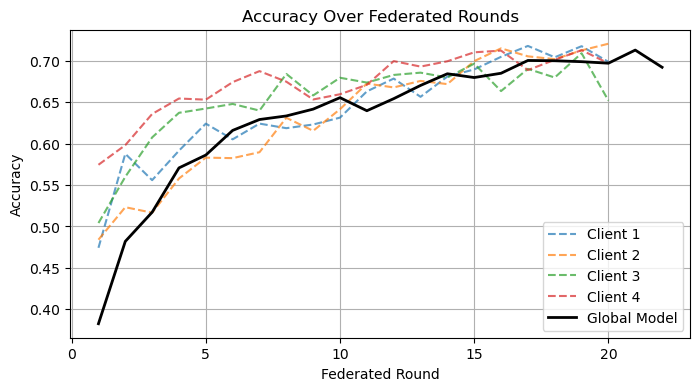

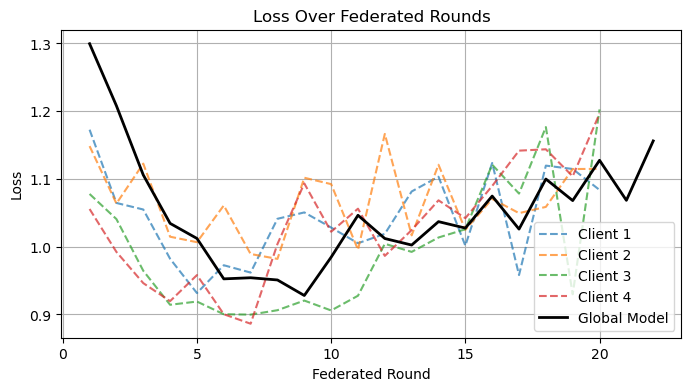

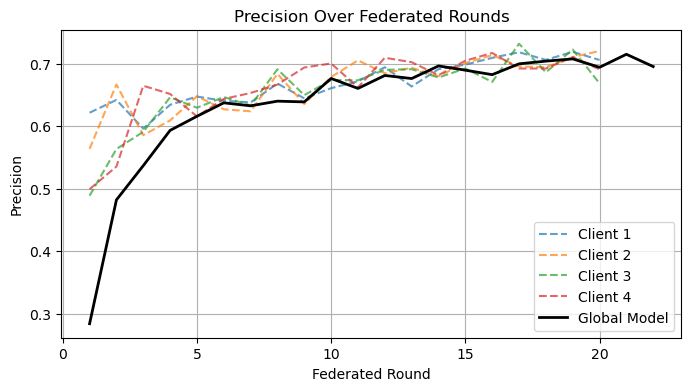

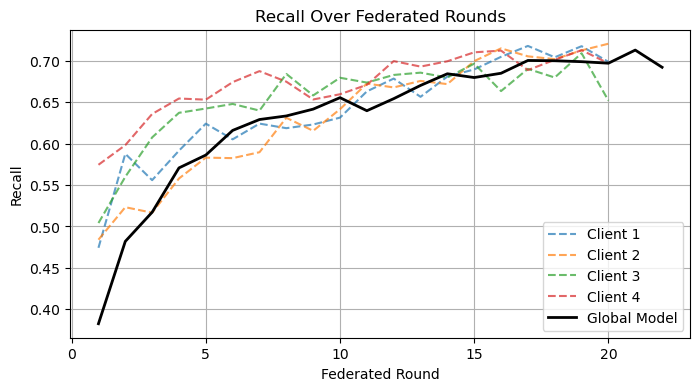

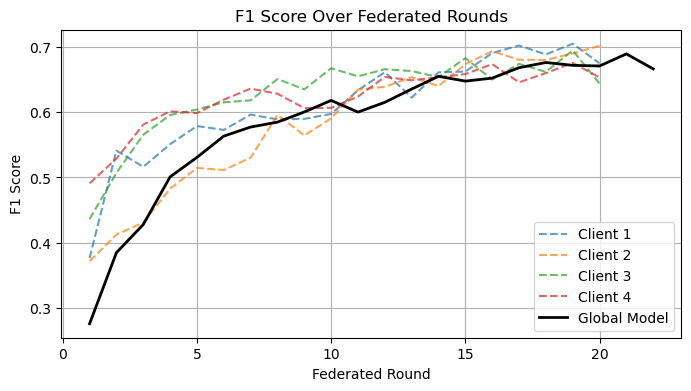

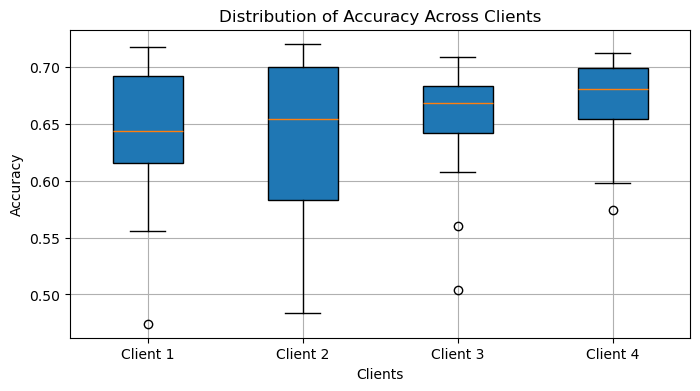

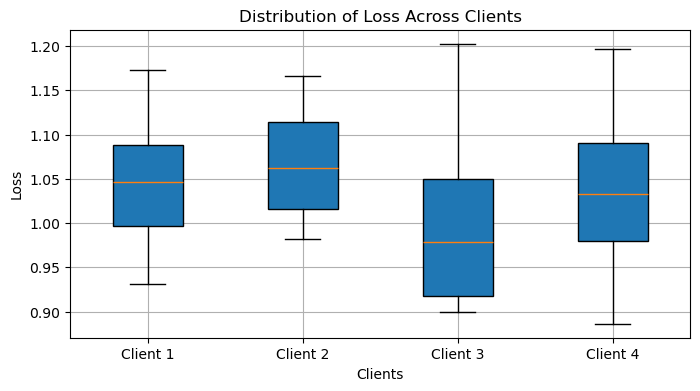

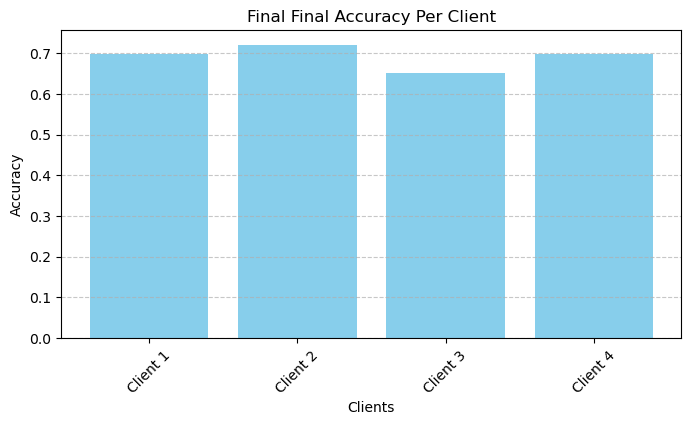

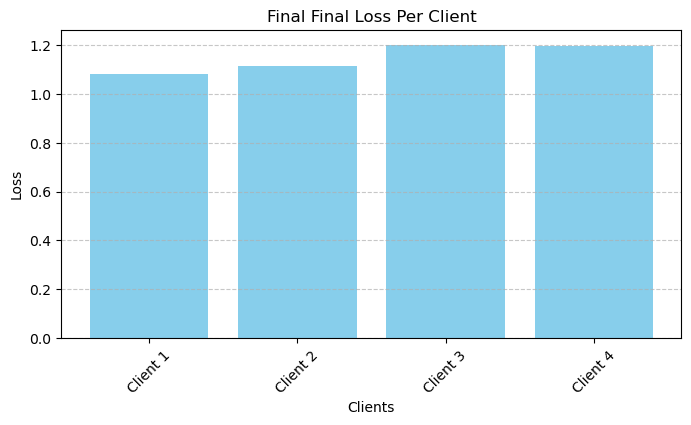

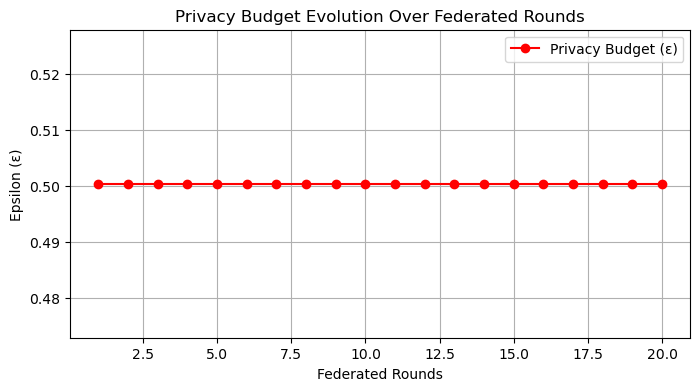


🔐 Initial Privacy Budget: ε = 0.50
🔐 Final Privacy Budget: ε = 0.50


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plot metric over rounds
def plot_metric(metric_name, client_values, global_values, ylabel):
    plt.figure(figsize=(8, 4))

    # Plot each client's metric (stored per round)
    for client_id, values in enumerate(client_values):
        rounds = list(range(1, len(values) + 1))
        plt.plot(rounds, values, label=f"Client {client_id+1}", linestyle="dashed", alpha=0.7)

    # Plot global model metric
    plt.plot(range(1, len(global_values) + 1), global_values, label="Global Model", linewidth=2, color="black")

    plt.xlabel("Federated Round")
    plt.ylabel(ylabel)
    plt.title(f"{metric_name} Over Federated Rounds")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Box plot of client final metrics
def box_plot_metric(metric_name, client_values, ylabel):
    plt.figure(figsize=(8, 4))
    plt.boxplot(client_values, vert=True, patch_artist=True)
    plt.xlabel("Clients")
    plt.ylabel(ylabel)
    plt.title(f"Distribution of {metric_name} Across Clients")
    plt.xticks(range(1, len(client_values) + 1), [f"Client {i+1}" for i in range(len(client_values))])
    plt.grid(True)
    plt.show()

# Bar chart of client final values
def bar_plot_metric(metric_name, client_values, ylabel):
    plt.figure(figsize=(8, 4))
    avg_final_values = [values[-1] for values in client_values]
    clients = [f"Client {i+1}" for i in range(len(client_values))]
    plt.bar(clients, avg_final_values, color="skyblue")
    plt.xlabel("Clients")
    plt.ylabel(ylabel)
    plt.title(f"Final {metric_name} Per Client")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

#  Extract per-client data for each metric
client_train_acc = [client_train_history[i]["accuracy"] for i in client_train_history]
client_train_loss = [client_train_history[i]["loss"] for i in client_train_history]
client_train_prec = [client_train_history[i]["precision"] for i in client_train_history]
client_train_rec = [client_train_history[i]["recall"] for i in client_train_history]
client_train_f1 = [client_train_history[i]["f1"] for i in client_train_history]
client_train_eps = [client_train_history[i]["epsilon"] for i in client_train_history]

# Plot metrics over federated rounds
plot_metric("Accuracy", client_train_acc, train_accuracy, "Accuracy")
plot_metric("Loss", client_train_loss, train_losses, "Loss")
plot_metric("Precision", client_train_prec, train_precision, "Precision")
plot_metric("Recall", client_train_rec, train_recall, "Recall")
plot_metric("F1 Score", client_train_f1, train_f1, "F1 Score")
#plot_metric("Epsilon", client_train_eps, train_epsilons, "Epsilon")

#  Compare final client performances
box_plot_metric("Accuracy", client_train_acc, "Accuracy")
box_plot_metric("Loss", client_train_loss, "Loss")

bar_plot_metric("Final Accuracy", client_train_acc, "Accuracy")
bar_plot_metric("Final Loss", client_train_loss, "Loss")

# Privacy plot
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(epsilon_per_round) + 1), epsilon_per_round, marker="o", linestyle="-", color="red", label="Privacy Budget (ε)")
plt.xlabel("Federated Rounds")
plt.ylabel("Epsilon (ε)")
plt.title("Privacy Budget Evolution Over Federated Rounds")
plt.legend()
plt.grid(True)
plt.show()

# Show initial and final privacy budget
print(f"\n🔐 Initial Privacy Budget: ε = {epsilon_per_round[0]:.2f}")
print(f"🔐 Final Privacy Budget: ε = {epsilon_per_round[-1]:.2f}")
